# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

# Vypracování

Načteme knihovny

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Načteme soubor data.csv do proměnné a podíváme se, jaké typy příznaky máme, abychom dle potřeby je převedly na takový typ, který modely dokážou přijat.

## Předzpracování vstupního souboru

Načteme data.csv do proměnné data a podíváme, jaké příznaky datové typy mají. Poslouží to k tomu, abychom věděli, jestli je potřeba něco upravovat.

In [2]:
data = pd.read_csv('data.csv') 
display(data.dtypes)

ID             int64
survived       int64
pclass         int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
home.dest     object
dtype: object

### Zpracování nedefinovaných hodnot

Podíváme se, jestli vůbec nedefinované hodnoty jsou ve vstupním souboru

In [3]:
display(data.isnull().sum())

ID             0
survived       0
pclass         0
name           0
sex            0
age          198
sibsp          0
parch          0
ticket         0
fare           1
cabin        767
embarked       2
home.dest    434
dtype: int64

Vidíme, že v příznacích age, fare, cabin, embarked, home.dest existují nedefinované hodnoty, které nahradíme -1.

In [4]:
data[["age",  "fare", "cabin", "embarked", "home.dest"]] = data[["age", "fare", "cabin", "embarked", "home.dest"]].replace(np.nan, -1)

Podíváme se, jestli vše dobře dopadlo

In [5]:
display(data.isnull().sum())

ID           0
survived     0
pclass       0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
home.dest    0
dtype: int64

### Převedení 
Je na čase převést příznaky typů objekt na takové typy, které příjme model. Nejdříve z tabulky odstraníme příznaky, které sice mohou mít vliv na výsledný model, ale jejich vliv je malý. A to jsou name, cabin, ticket, home.dest. Tímto řešením se one-hot encoding snaz implementuje.

In [6]:
data.drop(columns=["name","cabin","ticket", "home.dest"], inplace=True)

Na každý příznak typu object nejdříve uložíme do stringCol

In [7]:
stringCol = data.select_dtypes(['object']).columns
display(data.info())
stringCol

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1000 non-null   int64  
 1   survived  1000 non-null   int64  
 2   pclass    1000 non-null   int64  
 3   sex       1000 non-null   object 
 4   age       1000 non-null   float64
 5   sibsp     1000 non-null   int64  
 6   parch     1000 non-null   int64  
 7   fare      1000 non-null   float64
 8   embarked  1000 non-null   object 
dtypes: float64(2), int64(5), object(2)
memory usage: 70.4+ KB


None

Index(['sex', 'embarked'], dtype='object')

Převedeme tyto příznaky do typu kategorie, na které pak aplikujeme one-hot encoding. Na konci se podíváme, jestli se to povedlo.

In [8]:
data.info()
stringCol = data.select_dtypes(['object']).columns
data[stringCol] = data[stringCol].astype('category')
data = pd.get_dummies(data) 
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1000 non-null   int64  
 1   survived  1000 non-null   int64  
 2   pclass    1000 non-null   int64  
 3   sex       1000 non-null   object 
 4   age       1000 non-null   float64
 5   sibsp     1000 non-null   int64  
 6   parch     1000 non-null   int64  
 7   fare      1000 non-null   float64
 8   embarked  1000 non-null   object 
dtypes: float64(2), int64(5), object(2)
memory usage: 70.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           1000 non-null   int64  
 1   survived     1000 non-null   int64  
 2   pclass       1000 non-null   int64  
 3   age          1000 non-null   float64
 4   sibsp        1000 non-null   int64  
 5 

None

### Rozdělení dat na trénovácí, validační a testovací množinu

Nejdříve rozdělíme příznaky na vysvětlovanou proměnnou a skupinu příznaků, který se snaží vysvětlovanou proměnnou vysvětlit. V tomto případě je příznak survived vysvětlovaná proměnná a ostatní příznaky se ji budou snažit vysvětlit.
Do Xdata přiřadíme všechny příznaky kromě příznaku Survived. Do Ydata přiřadíme příznak survived.

In [9]:
#Rozdělění dat na množiny
Xdata = data.drop("survived", axis = 1)
Ydata = data.survived 
display(Xdata)
display(Ydata)

,ID,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_-1,embarked_C,embarked_Q,embarked_S
0,0,3,11.0,5,2,46.9000,False,True,False,False,False,True
1,1,3,-1.0,0,0,7.0500,False,True,False,False,False,True
2,2,3,4.0,3,2,27.9000,False,True,False,False,False,True
3,3,3,-1.0,1,0,15.5000,True,False,False,False,True,False
4,4,3,18.0,0,0,7.2292,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,2,52.0,0,0,13.0000,False,True,False,False,False,True
996,996,2,29.0,0,0,10.5000,False,True,False,False,False,True
997,997,1,56.0,0,0,26.5500,False,True,False,False,False,True
998,998,1,25.0,1,0,55.4417,False,True,False,True,False,False


0      0
1      0
2      0
3      1
4      1
      ..
995    0
996    0
997    0
998    1
999    0
Name: survived, Length: 1000, dtype: int64

V tomto kroku nastavíme seed a rozdělíme data nejdříve na 2 množiny. A to na trenovácí a zbytek, kde zbytek pak rozdělíme na validační a testovací.

In [10]:
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, Ydata, test_size=0.4, random_state=rd_seed) 
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=rd_seed) 

## Model

### Rozhodovací strom

Rozhodovací strom lze použít pro klasifikační úlohu. Má ale sklon k přeučení. Zejména u velkých stromů.

Načteme potřebné knihovny pro práci s rozhodovacím stromem a s grafy.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics
import matplotlib
import matplotlib.pyplot as plt

Jako hyperparametr daného modelu je hloubka. Dále zvolíme interval od 1 do 101, který může hloubka nabývat. Do akumulátorů budeme zaznamenávat, na kolik je přesný model pro trénovací data a pro validační data, které dále použijeme.

In [12]:
val_acc = []
train_acc = []
accuracy_acc= []
depths = range(1,101)
for i in depths :
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clf.predict(Xval)))
bestDecisionTreeIndex = val_acc.index(max(val_acc)) + 1

Na základě měření přesností v rámci trénovací a validační množiny vytvoříme graf. Vidíme, že z hlediska validační množiny je nejlepší zvolit hloubku kolem 6. Přesnější informaci najdeme v proměnné bestDecisionTreeIndex.

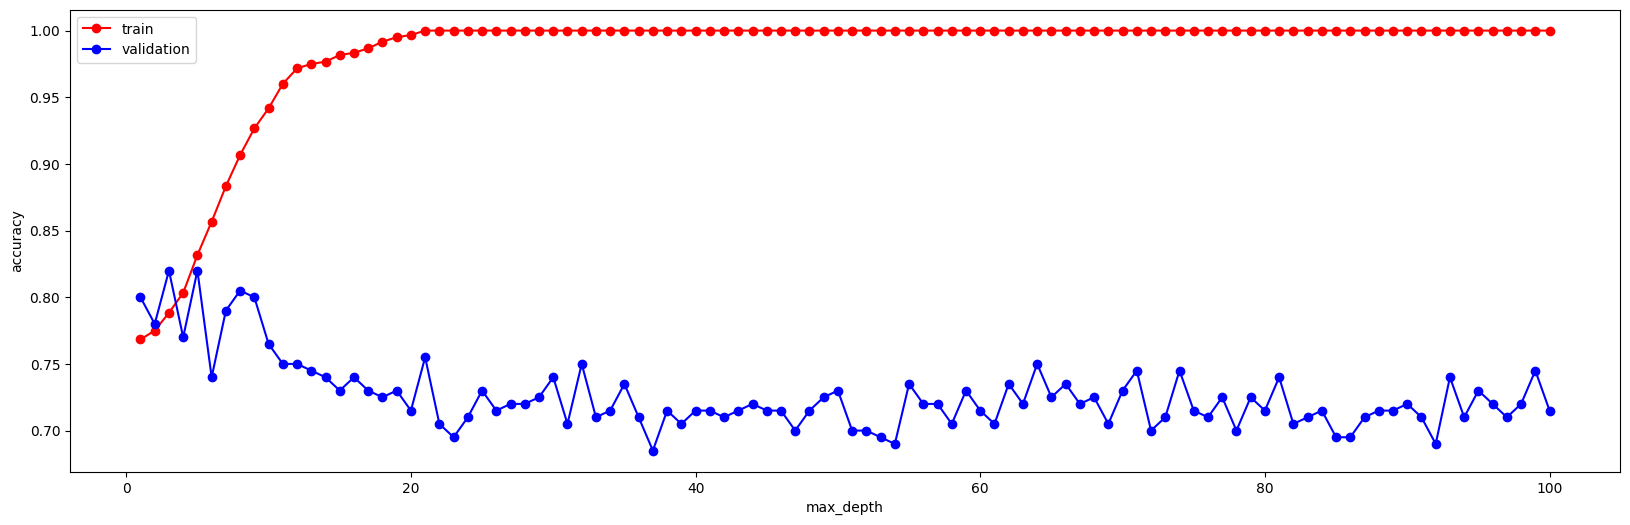

In [13]:
plt.figure(figsize=(20,6))
plt.plot(depths, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(depths, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

Nejlepší model znova natrénujeme a podíváme se, jak vypadá přesnost na validační množině, ROC křívka, AUC hodnota a F1 hodnota, které použijeme pro volbu mezi rozhodovacím stromem a KNN metodou.

In [14]:
bestDecisionTree = DecisionTreeClassifier(max_depth=bestDecisionTreeIndex)
bestDecisionTree.fit(Xtrain, ytrain)
print('Accuracy score (validate): {0:.6f}'.format(metrics.accuracy_score(yval, bestDecisionTree.predict(Xval))))

Accuracy score (validate): 0.820000


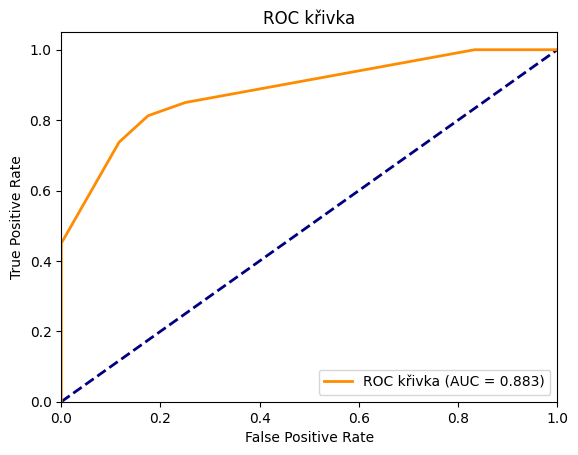

In [15]:
y_pred_proba = bestDecisionTree.predict_proba(Xval)
fpr, tpr, thresholds = metrics.roc_curve(yval, y_pred_proba[:,1])

AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()

In [16]:
print(f'F1 score (validate): {metrics.f1_score(yval, bestDecisionTree.predict(Xval)):.4f}')

F1 score (validate): 0.7831


### KNN metoda

KNN metodu lze použít pro klasifikační úlohu. Má ale potíže s kategoriálními daty, které jsme zakódovali nebo se jich zbavili. 

Načteme potřebné knihovny

In [17]:
from sklearn.preprocessing import MinMaxScaler

Provedeme normalizaci dat a to pomocí min-max normalizace 

In [18]:
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

Jako hyperparametr pro KNN zvolíme počet sousedu, který se budou podílet na predikci

In [20]:
val_acc = []
train_acc = []
kneighbors = range(1, 101)

for i in kneighbors :
    clfKNN = KNeighborsClassifier(n_neighbors = i)
    clfKNN.fit(Xtrain_scaled, ytrain)
    val_acc.append(clfKNN.score(Xval_scaled, yval))
    train_acc.append(clfKNN.score(Xtrain_scaled, ytrain))
bestKNN = val_acc.index(max(val_acc)) + 1  

Podíváme se na to, jak se mění přesnost na základě zvoleného hyperparametru pro trénovací a validační množinu

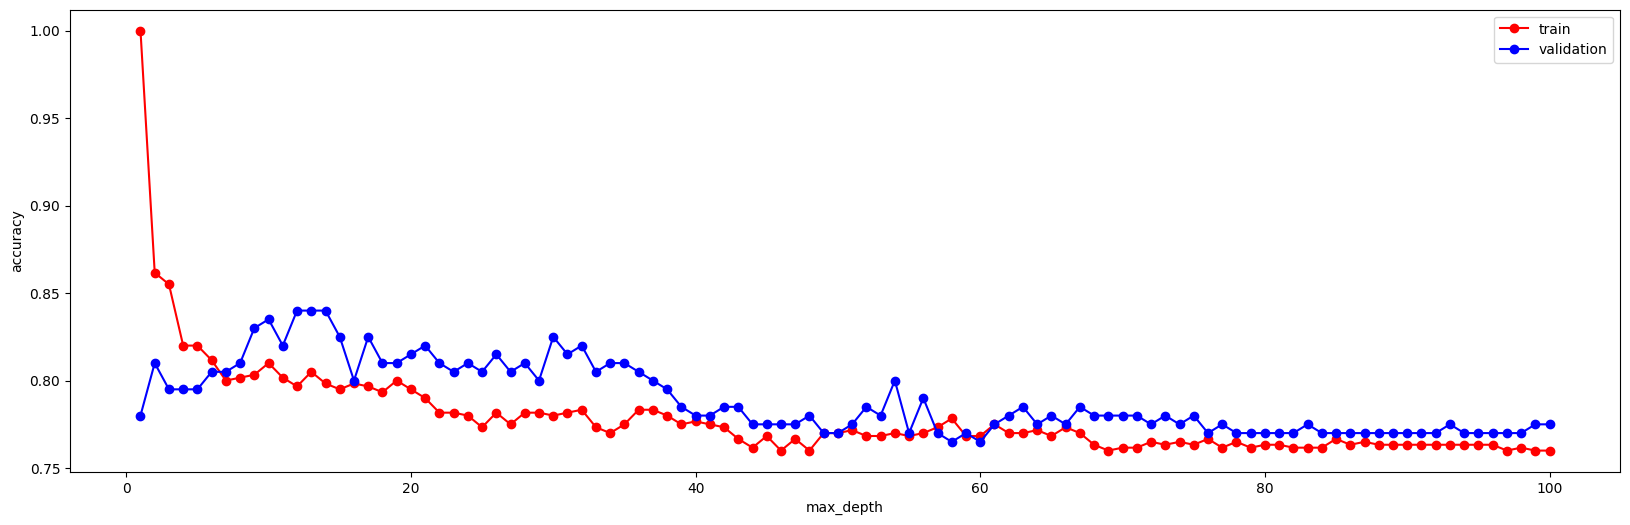

In [21]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(kneighbors, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(kneighbors, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

Nejlepší model znova natrenujeme a podívame se, jak vypadá přesnost na validační množině, ROC křívka, AUC hodnota a F1 hodnota, které použijeme pro volbu mezi rozhodvacím stromem a KNN metodou.

In [22]:
clfKNNBest = KNeighborsClassifier(n_neighbors = bestKNN)
clfKNNBest.fit(Xtrain_scaled, ytrain)
print('Accuracy score (validate): {0:.6f}'.format(metrics.accuracy_score(yval, clfKNNBest.predict(Xval_scaled))))



Accuracy score (validate): 0.840000


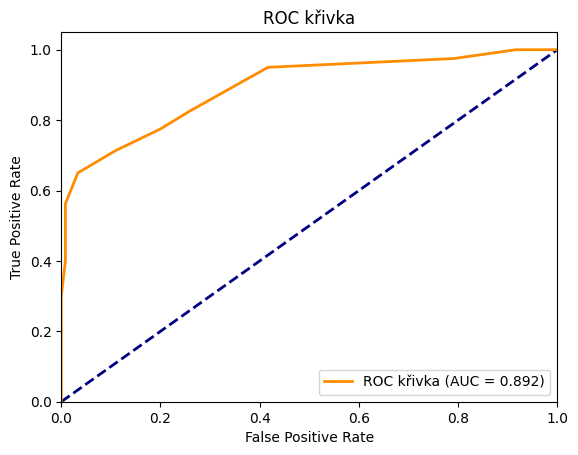

In [23]:
y_pred_proba = clfKNNBest.predict_proba(Xval_scaled)
fpr, tpr, thresholds = metrics.roc_curve(yval, y_pred_proba[:,1])

AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()

In [24]:
print(f'F1 score (validate): {metrics.f1_score(yval, clfKNNBest.predict(Xval_scaled)):.4f}')

F1 score (validate): 0.7647


## Volba mezi rozhodovacím stromem a KNN metodou

Podíváme se, na kolik jsou trénovací a validační data vyvážena. V případě nevyváženosti bych volil na základě AUC. Příznak, který chceme predikovat, je zlehka nevyvážený.

In [25]:
display(ytrain.value_counts(normalize=True))
display(yval.value_counts(normalize=True))

survived
0    0.616667
1    0.383333
Name: proportion, dtype: float64

survived
0    0.6
1    0.4
Name: proportion, dtype: float64

protože data jsou vícé méně vyvážená a F1 score je u derivačního patrně vyšší, vybereme rozhodovací strom.

## Predikce na testovacím datasetu

Spočítáme přesnost na validační množině, ROC křivku, AUC hodnotu a F1 hodnotu.

In [26]:
print(f'predikce rozhodovacího stromu na testovacích datech + {metrics.accuracy_score(ytest, bestDecisionTree.predict(Xtest))}')

predikce rozhodovacího stromu na testovacích datech + 0.75


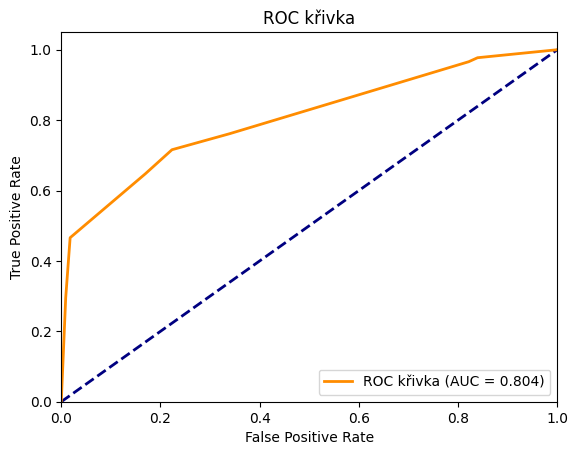

In [27]:
y_pred_proba = bestDecisionTree.predict_proba(Xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, y_pred_proba[:,1])

AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()

In [28]:
print(f'F1 score (test): {metrics.f1_score(ytest, bestDecisionTree.predict(Xtest)):.4f}')

F1 score (test): 0.7159


## Evaluace

### Předzpracování dat pro evaluation.csv

Načteme soubor evaluation.csv do proměnné dataEval a podíváme, jaké příznaky je potřeba upravit. Provedeme podobné operace s daty, jaké jsme provedli se souborem data.csv.

In [29]:
dataEval = pd.read_csv('evaluation.csv')
display(dataEval.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         309 non-null    int64  
 1   pclass     309 non-null    int64  
 2   name       309 non-null    object 
 3   sex        309 non-null    object 
 4   age        244 non-null    float64
 5   sibsp      309 non-null    int64  
 6   parch      309 non-null    int64  
 7   ticket     309 non-null    object 
 8   fare       309 non-null    float64
 9   cabin      62 non-null     object 
 10  embarked   309 non-null    object 
 11  home.dest  179 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 29.1+ KB


None

Podíváme se na to, kolik máme nevyplněných hodnot

In [30]:
display(dataEval.isnull().sum())

ID             0
pclass         0
name           0
sex            0
age           65
sibsp          0
parch          0
ticket         0
fare           0
cabin        247
embarked       0
home.dest    130
dtype: int64

Co se týče příznaků, které obsahují nevyplněné hodnoty, namísto nevyplněné hodnoty doplníme -1.

In [31]:
dataEval[["age", "cabin", "home.dest"]] = dataEval[["age", "cabin", "home.dest"]].replace(np.nan, -1)

Podíváme se, jestli vše je v pořádku.

In [32]:
display(dataEval.isnull().sum())

ID           0
pclass       0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
home.dest    0
dtype: int64

Smažeme některé příznaky. Poté převedeme příznaky typu objekt na typ, který příjme model. Musíme ale doplnit embarked_-1, protože všechny hodnoty v příznaku embarked jsou vyplněné.

In [33]:
dataEval.drop(columns=["name","cabin","ticket", "home.dest"], inplace=True)
stringCol = dataEval.select_dtypes(['object']).columns
dataEval[stringCol] = dataEval[stringCol].astype('category')

display(stringCol)
dataEval = pd.get_dummies(dataEval) 
dataEval.insert(data.columns.get_loc("embarked_-1") - 1,"embarked_-1", -1)
display(dataEval.info())
display(data.info())

Index(['sex', 'embarked'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           309 non-null    int64  
 1   pclass       309 non-null    int64  
 2   age          309 non-null    float64
 3   sibsp        309 non-null    int64  
 4   parch        309 non-null    int64  
 5   fare         309 non-null    float64
 6   sex_female   309 non-null    bool   
 7   sex_male     309 non-null    bool   
 8   embarked_-1  309 non-null    int64  
 9   embarked_C   309 non-null    bool   
 10  embarked_Q   309 non-null    bool   
 11  embarked_S   309 non-null    bool   
dtypes: bool(5), float64(2), int64(5)
memory usage: 18.5 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           1000 non-null   int64  
 1   survived     1000 non-null   int64  
 2   pclass       1000 non-null   int64  
 3   age          1000 non-null   float64
 4   sibsp        1000 non-null   int64  
 5   parch        1000 non-null   int64  
 6   fare         1000 non-null   float64
 7   sex_female   1000 non-null   bool   
 8   sex_male     1000 non-null   bool   
 9   embarked_-1  1000 non-null   bool   
 10  embarked_C   1000 non-null   bool   
 11  embarked_Q   1000 non-null   bool   
 12  embarked_S   1000 non-null   bool   
dtypes: bool(6), float64(2), int64(5)
memory usage: 60.7 KB


None

### Spočítání predikce pro data ze souboru evaluation.csv a uložení výsledku do result.csv

In [34]:
prediction = bestDecisionTree.predict(dataEval)
res = pd.concat([pd.read_csv('evaluation.csv')["ID"], pd.Series(prediction, name="survived")], axis = 1)
display(res)
res.to_csv('result.csv', index=False)

,ID,survived
0,1000,0
1,1001,1
2,1002,1
3,1003,0
4,1004,1
...,...,...
304,1304,0
305,1305,0
306,1306,0
307,1307,1
